In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from collections import Counter
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------- USER-CHANGEABLE HYPERPARAMS --------------------------
SEED = 42
SEQUENCE_LENGTH = 10       # window length 
TEST_SIZE = 0.2
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 105
DROPOUT_P = 0.5
# -------------------------------------------------------------------------------
#data
FEATURE_COLS = ['ax', 'ay', 'az', 'wx', 'wy', 'wz', 'speed']
TARGET_COL = 'roadCondition'
DATA_FILE = '../data/combined.csv'
CHUNK_SIZE = 80 #while splitting 

# ---------- Reproducibility ----------
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


LOAD DATA


In [41]:

df = pd.read_csv(DATA_FILE)
# Drop rows with missing values in our key columns
df = df.dropna(subset=FEATURE_COLS + [TARGET_COL])

# Encode the target variable ('Good', 'Bad') into numbers (e.g., 0, 1)
le = LabelEncoder()
df[TARGET_COL] = le.fit_transform(df[TARGET_COL])

print(f"Data loaded. Found {len(df)} valid rows.")
print(f"Target classes: {le.classes_} -> {le.transform(le.classes_)}")

# Separate features and labels
features = df[FEATURE_COLS]
labels = df[TARGET_COL]
X_raw = features
labels_raw = labels



Data loaded. Found 11803 valid rows.
Target classes: ['Bad' 'Good'] -> [0 1]


scaling 

In [42]:

# --------------------- 1) Scale full dataset (important!) ---------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)   # shape: (num_rows, num_features)


Windowing, this converts the data form (total_rows, 7) -> (num_window, 10, 7)

In [43]:

# --------------------- 2) Create windowed sequences (before any split) ---------------------
def majority_label(window_labels):
    # Accepts numpy array or list, returns the most common label (ties -> smallest label)
    counts = Counter(window_labels.tolist() if isinstance(window_labels, np.ndarray) else window_labels)
    most_common_label = counts.most_common(1)[0][0]
    return most_common_label

def create_windowed_sequences(X_rows, labels_rows, seq_len):
    """
    X_rows: numpy array (num_rows, num_features)
    labels_rows: 1D array (num_rows,)
    returns:
       X_windows: np.array (num_windows, seq_len, num_features)
       y_windows: np.array (num_windows,)   # majority label in each window
    """
    n_rows = len(X_rows)
    if n_rows < seq_len:
        raise ValueError("Not enough rows to create even one window. Decrease SEQUENCE_LENGTH.")
    X_out = []
    y_out = []
    # inclusive last window -> use range(n_rows - seq_len + 1)
    for i in range(n_rows - seq_len + 1):
        wX = X_rows[i : i + seq_len]            # shape (seq_len, features)
        wY = labels_rows[i : i + seq_len]       # shape (seq_len,)
        X_out.append(wX)
        y_out.append(majority_label(wY))
    return np.array(X_out), np.array(y_out)

X_all, y_all = create_windowed_sequences(X_scaled, labels_raw, SEQUENCE_LENGTH)
print("Windowed data shapes (windows, seq_len, features):", X_all.shape)
print("Windowed labels shape:", y_all.shape)
print("Label distribution (windows):", dict(Counter(y_all)))


Windowed data shapes (windows, seq_len, features): (11794, 10, 7)
Windowed labels shape: (11794,)
Label distribution (windows): {1: 6476, 0: 5318}


SPLITTING

In [44]:

# --------------------- 3) Train/Test split on windows ---------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, shuffle=True, random_state=SEED, stratify=y_all
)
print("After split - train windows:", X_train.shape, "test windows:", X_test.shape)
print("Train label distribution:", dict(Counter(y_train)))
print("Test label distribution:", dict(Counter(y_test)))

# --------------------- 4) Transpose to channels-first for Conv1d ---------------------
# PyTorch Conv1d wants (batch, channels, seq_len)
# Currently windows are (batch, seq_len, features) -> transpose to (batch, features, seq_len)
X_train_t = np.transpose(X_train, (0, 2, 1)).astype(np.float32)
X_test_t  = np.transpose(X_test,  (0, 2, 1)).astype(np.float32)
y_train_np = y_train.astype(np.float32)
y_test_np  = y_test.astype(np.float32)

print("Post-transpose shapes (batch, channels, seq_len):", X_train_t.shape)


After split - train windows: (9435, 10, 7) test windows: (2359, 10, 7)
Train label distribution: {1: 5181, 0: 4254}
Test label distribution: {0: 1064, 1: 1295}
Post-transpose shapes (batch, channels, seq_len): (9435, 7, 10)


pytorch dataset & DataLoader

In [45]:

# --------------------- 5) PyTorch Dataset & DataLoader ---------------------
class WindowDataset(Dataset):
    def __init__(self, X_np, y_np):
        self.X = torch.from_numpy(X_np)         # float32
        self.y = torch.from_numpy(y_np).unsqueeze(1)  # shape (N,1) for BCEWithLogitsLoss
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = WindowDataset(X_train_t, y_train_np)
test_ds  = WindowDataset(X_test_t, y_test_np)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


Model building

In [46]:

# --------------------- 6) Build the model ---------------------
class RoadCNN(nn.Module):
    def __init__(self, input_channels, seq_length, dropout_p=DROPOUT_P):
        super(RoadCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten = nn.Flatten()

        # compute flattened size with a dummy forward pass
        with torch.no_grad():
            dummy = torch.randn(1, input_channels, seq_length)
            out = self.pool2(self.relu2(self.conv2(self.pool1(self.relu1(self.conv1(dummy))))))
            flat_size = out.shape[1] * out.shape[2]

        self.fc1 = nn.Linear(flat_size, 100)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = RoadCNN(input_channels=X_train_t.shape[1], seq_length=X_train_t.shape[2]).to(device)
print(model)


RoadCNN(
  (conv1): Conv1d(7, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


loss with pos_weight to handle imbalance

In [47]:
print (X_train_t.shape[0], X_train_t.shape[2])

9435 10


In [48]:

# --------------------- 7) Loss with pos_weight for imbalance ---------------------
# Calculate pos_weight = (neg / pos)
train_counts = Counter(y_train)
pos = train_counts.get(1, 0)
neg = train_counts.get(0, 0)
if pos == 0:
    raise RuntimeError("No positive samples in training set. Can't train.")
pos_weight_val = torch.tensor([neg / pos], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("pos_weight used in loss:", pos_weight_val.item())


pos_weight used in loss: 0.8210769891738892


training loop

In [49]:

# --------------------- 8) Training loop (modified to collect metrics & return probs) ---------------------
def train_epoch(model, loader, optim, crit):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        optim.zero_grad()
        logits = model(Xb)
        loss = crit(logits, yb)
        loss.backward()
        optim.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader, crit=None):
    """Return: avg_loss (or None), probs_array, preds_array, trues_array"""
    model.eval()
    total_loss = 0.0
    preds_all = []
    trues_all = []
    probs_all = []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            yb = yb.to(device)
            logits = model(Xb)
            if crit is not None:
                total_loss += crit(logits, yb).item() * Xb.size(0)
            probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
            preds = (probs >= 0.5).astype(int)
            probs_all.extend(probs.tolist())
            preds_all.extend(preds.tolist())
            trues_all.extend(yb.cpu().numpy().reshape(-1).tolist())
    avg_loss = (total_loss / len(loader.dataset)) if crit is not None else None
    return avg_loss, np.array(probs_all), np.array(preds_all), np.array(trues_all)

# Collect history
best_test_acc = 0.0
train_losses = []
test_losses = []
test_accs = []
epoch_aucs = []

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    test_loss, probs_test, preds_test, trues_test = eval_model(model, test_loader, criterion)

    # basic metrics
    test_acc = (preds_test == trues_test).mean()
    # ROC AUC: may fail if only one class present -> handle
    try:
        roc_auc = roc_auc_score(trues_test, probs_test)
    except ValueError:
        roc_auc = float('nan')

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    epoch_aucs.append(roc_auc)

    print(f"Epoch {epoch:02d} | train_loss: {train_loss:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f} | roc_auc: {roc_auc if not np.isnan(roc_auc) else 'N/A'}")

    # optional: save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), "best_roadcnn.pth")


Epoch 01 | train_loss: 0.5305 | test_loss: 0.4551 | test_acc: 0.7541 | roc_auc: 0.8326145963364008
Epoch 02 | train_loss: 0.4308 | test_loss: 0.3894 | test_acc: 0.7851 | roc_auc: 0.8806644990855517
Epoch 02 | train_loss: 0.4308 | test_loss: 0.3894 | test_acc: 0.7851 | roc_auc: 0.8806644990855517
Epoch 03 | train_loss: 0.3689 | test_loss: 0.3394 | test_acc: 0.8270 | roc_auc: 0.9117818677969055
Epoch 03 | train_loss: 0.3689 | test_loss: 0.3394 | test_acc: 0.8270 | roc_auc: 0.9117818677969055
Epoch 04 | train_loss: 0.3173 | test_loss: 0.3169 | test_acc: 0.8364 | roc_auc: 0.9265531105756668
Epoch 04 | train_loss: 0.3173 | test_loss: 0.3169 | test_acc: 0.8364 | roc_auc: 0.9265531105756668
Epoch 05 | train_loss: 0.2716 | test_loss: 0.2960 | test_acc: 0.8516 | roc_auc: 0.9357694429123
Epoch 05 | train_loss: 0.2716 | test_loss: 0.2960 | test_acc: 0.8516 | roc_auc: 0.9357694429123
Epoch 06 | train_loss: 0.2365 | test_loss: 0.2475 | test_acc: 0.8724 | roc_auc: 0.9549314889540453
Epoch 06 | train

model evaluation on the model with best test accuracy

C:\Users\nishk\AppData\Local\Temp\ipykernel_39424\3358004456.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_roadcnn.pth"))



--- Final classification report (test set) ---
              precision    recall  f1-score   support

         0.0     0.9548    0.9718    0.9632      1064
         1.0     0.9765    0.9622    0.9693      1295

    accuracy                         0.9665      2359
   macro avg     0.9656    0.9670    0.9662      2359
weighted avg     0.9667    0.9665    0.9665      2359



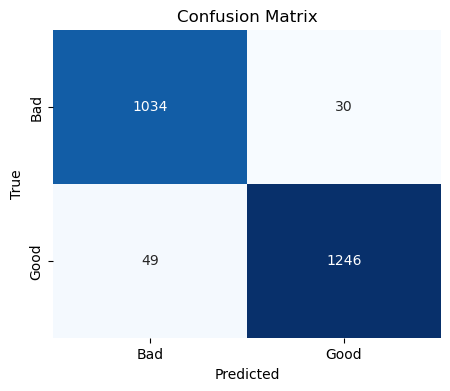

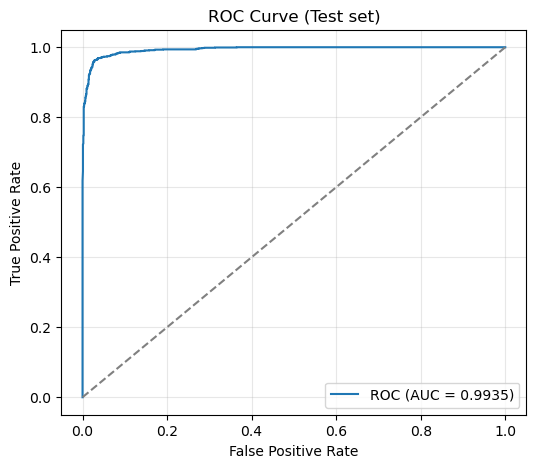

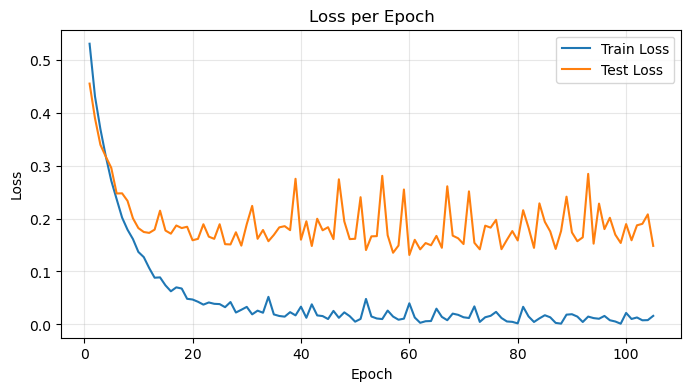

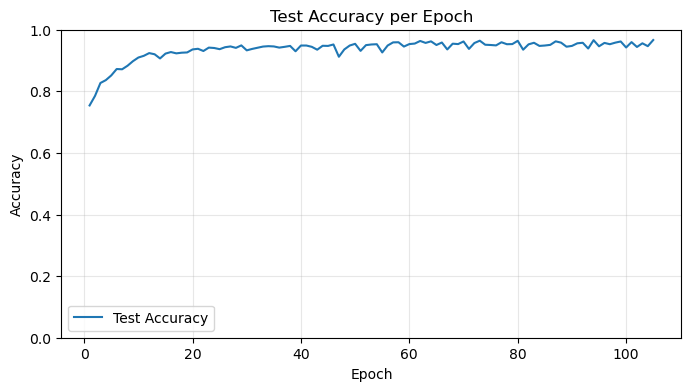

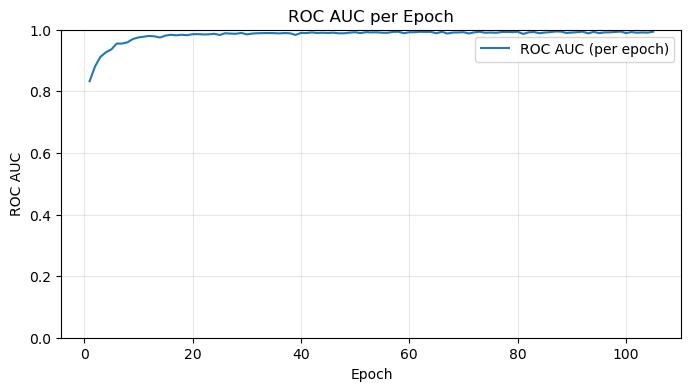

In [50]:
# Load the best model and evaluate + plotting (ROC, loss, accuracy over epochs)
model.load_state_dict(torch.load("best_roadcnn.pth"))

# Get final test probabilities/preds/trues using best model
_, probs_test, preds_test, trues_test = eval_model(model, test_loader, criterion)

print("\n--- Final classification report (test set) ---")
print(classification_report(trues_test, preds_test, digits=4))

cm = confusion_matrix(trues_test, preds_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve (best model on test set)
try:
    fpr, tpr, _ = roc_curve(trues_test, probs_test)
    auc_score = roc_auc_score(trues_test, probs_test)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.4f})')
    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test set)')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()
except ValueError:
    print('ROC curve not available (need both classes present in test labels).')

# Epoch-wise plots: Loss and Accuracy
epochs = np.arange(1, len(train_losses) + 1)
if len(epochs) > 0:
    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epochs, test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy per Epoch')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Optional: ROC AUC per epoch plot (if computed)
    try:
        if any(~np.isnan(epoch_aucs)):
            plt.figure(figsize=(8,4))
            plt.plot(epochs, epoch_aucs, label='ROC AUC (per epoch)')
            plt.xlabel('Epoch')
            plt.ylabel('ROC AUC')
            plt.title('ROC AUC per Epoch')
            plt.ylim(0,1)
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()
    except NameError:
        # epoch_aucs not present if training loop wasn't run in the current session
        pass
